In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Copy of CNN_assignment.zip" > /dev/null

In [62]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
from pathlib import Path

# Define the paths to your training and testing image directories
data_dir_train = Path(r"/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")  # Update with the correct path
data_dir_test = Path(r"/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")    # Update with the correct path

# Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Images:", image_count_train)

# Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Images:", image_count_test)


Train Images: 2239
Test Images: 118


Found 2239 files belonging to 9 classes.


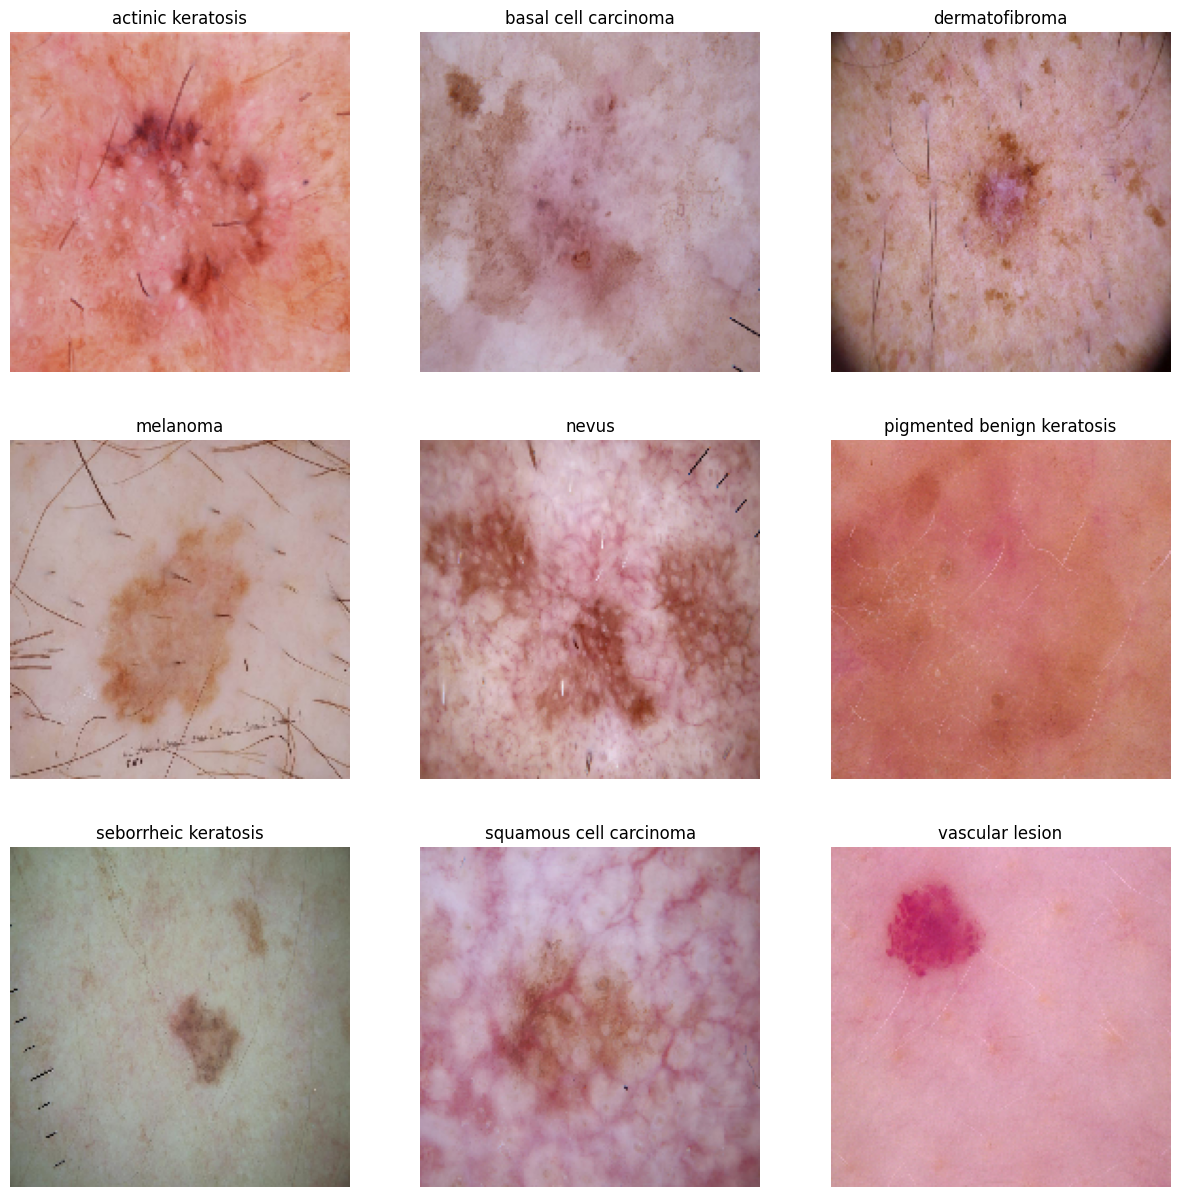

In [5]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [6]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,nevus,357
2,vascular lesion,139
3,squamous cell carcinoma,181
4,pigmented benign keratosis,462
5,seborrheic keratosis,77
6,melanoma,438
7,actinic keratosis,114
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

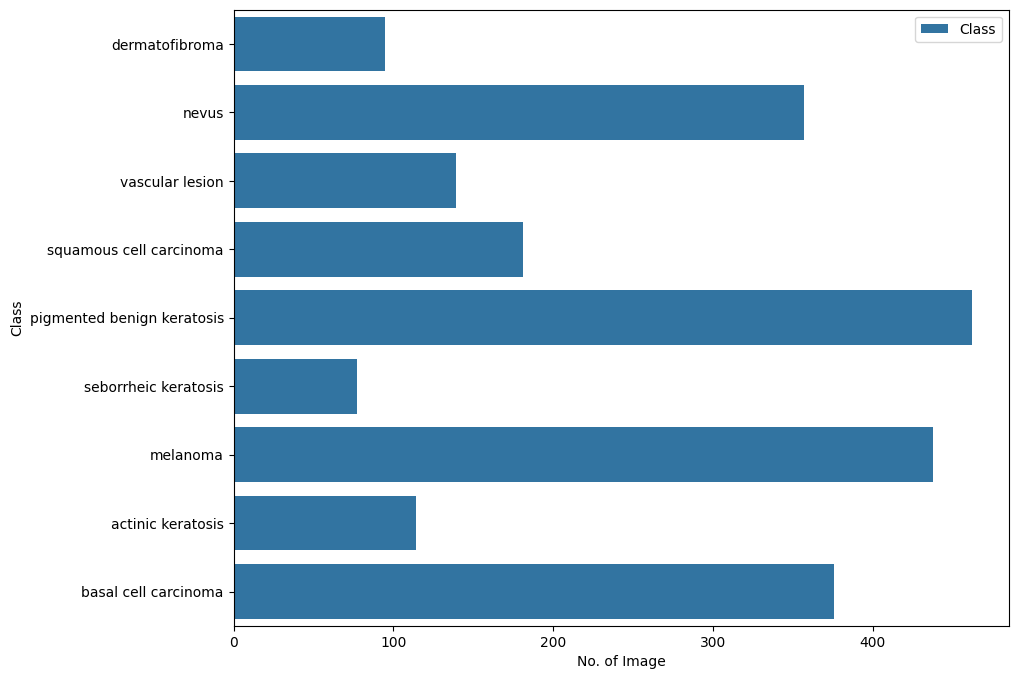

In [7]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [8]:
#install Augmentor
!pip install Augmentor

In [9]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FFEC4675D0>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FFEC113590>: 100%|██████████| 500/500 [00:17<00:00, 28.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FFEC4D3890>: 100%|██████████| 500/500 [00:15<00:00, 32.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x77FFEC6C2890>: 100%|██████████| 500/500 [01:18<00:00,  6.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x77FFEF4D0510>: 100%|██████████| 500/500 [01:14<00:00,  6.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7800ACAF7190>: 100%|██████████| 500/500 [00:13<00:00, 36.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x77FFEC0FE750>: 100%|██████████| 500/500 [00:35<00:00, 14.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x77FFEC35BF50>: 100%|██████████| 500/500 [00:13<00:00, 36.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FFEC2F7110>: 100%|██████████| 500/500 [00:13<00:00, 35.82 Samples/s]


In [10]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [11]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [12]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [13]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

# Define model architecture
model = Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Rescaling Layer

    # First Convolutional Layer
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Second Convolutional Layer
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Third Convolutional Layer
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Dropout Layer (50%)
    layers.Dropout(0.5),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),

    # Dropout Layer (25%)
    layers.Dropout(0.25),

    # Output Layer (Softmax)
    layers.Dense(len(class_names), activation='softmax')
])

# Print Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

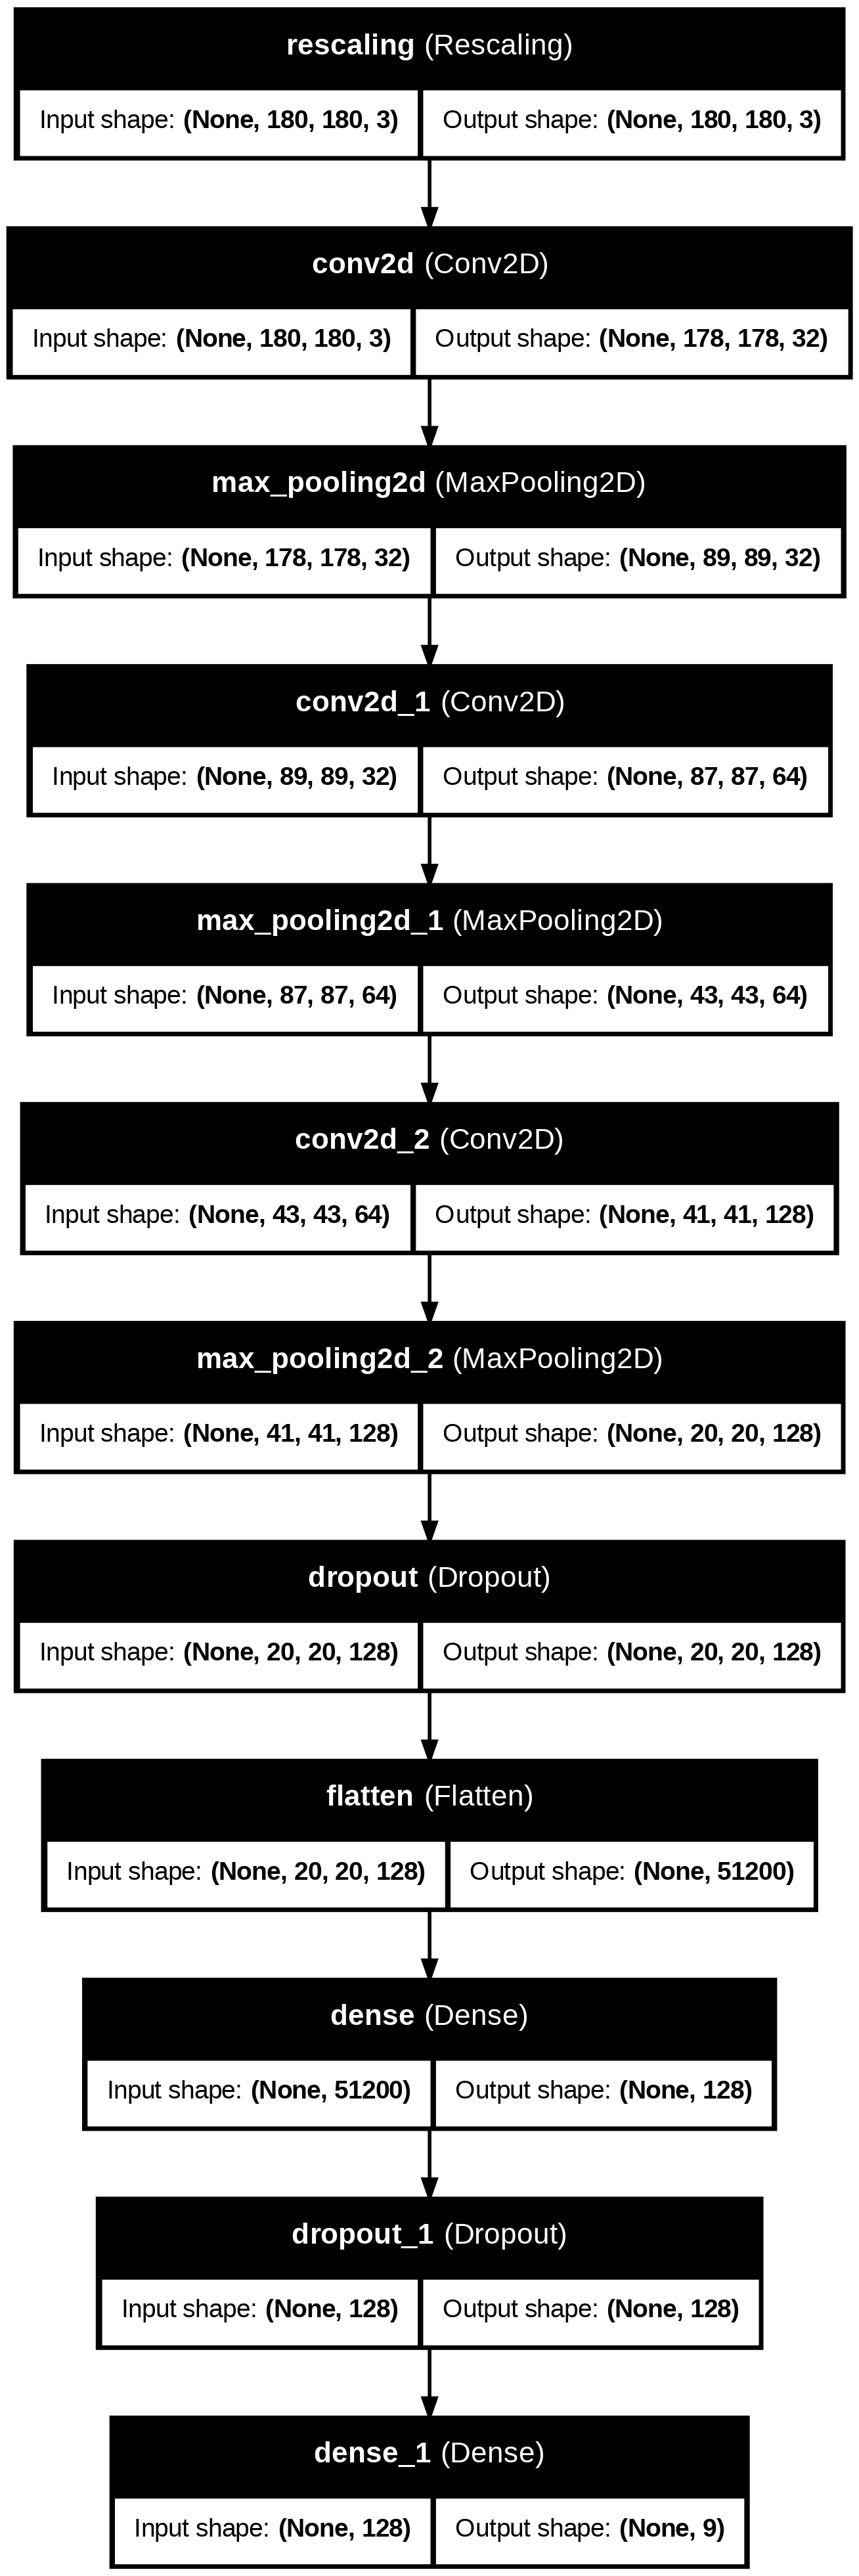

In [15]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [17]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2094 - loss: 2.0715
Epoch 1: val_accuracy improved from -inf to 0.44915, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - accuracy: 0.2104 - loss: 2.0690 - val_accuracy: 0.4491 - val_loss: 1.5170
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4128 - loss: 1.5482
Epoch 2: val_accuracy improved from 0.44915 to 0.51373, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4129 - loss: 1.5479 - val_accuracy: 0.5137 - val_loss: 1.3002
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5058 - loss: 1.2825
Epoch 3: val_accuracy did not improve from 0.51373
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5057 - loss: 1.2827 - val_accuracy: 0.4291 - val_loss: 1.5140
Epoch 4/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5440 - loss: 1.2552
Epoch 4: val_accuracy improved from 0.51373 to 0.58500, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5442 - loss: 1.2546 - val_accuracy: 0.5850 - val_loss: 1.0749
Epoch 5/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5932 - loss: 1.0598
Epoch 5: val_accuracy improved from 0.58500 to 0.60728, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5934 - loss: 1.0597 - val_accuracy: 0.6073 - val_loss: 1.0413
Epoch 6/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6351 - loss: 0.9518
Epoch 6: val_accuracy improved from 0.60728 to 0.61990, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6352 - loss: 0.9517 - val_accuracy: 0.6199 - val_loss: 0.9864
Epoch 7/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6838 - loss: 0.8369
Epoch 7: val_accuracy improved from 0.61990 to 0.65924, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6838 - loss: 0.8368 - val_accuracy: 0.6592 - val_loss: 0.8874
Epoch 8/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7195 - loss: 0.7509
Epoch 8: val_accuracy improved from 0.65924 to 0.69042, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7195 - loss: 0.7510 - val_accuracy: 0.6904 - val_loss: 0.8418
Epoch 9/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7462 - loss: 0.6974
Epoch 9: val_accuracy improved from 0.69042 to 0.71789, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7462 - loss: 0.6972 - val_accuracy: 0.7179 - val_loss: 0.8306
Epoch 10/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7716 - loss: 0.6480
Epoch 10: val_accuracy improved from 0.71789 to 0.78025, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7716 - loss: 0.6479 - val_accuracy: 0.7803 - val_loss: 0.6657
Epoch 11/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8127 - loss: 0.5090
Epoch 11: val_accuracy did not improve from 0.78025
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8127 - loss: 0.5092 - val_accuracy: 0.7773 - val_loss: 0.6590
Epoch 12/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8228 - loss: 0.4850
Epoch 12: val_accuracy did not improve from 0.78025
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8227 - loss: 0.4852 - val_accuracy: 0.7617 - val_loss: 0.6946
Epoch 13/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8248 - loss: 0.4832
Epoch 13: val_accuracy did not improve from 0.78025
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8248 - loss: 0.4834 - val_accuracy: 0.7409 - val_loss: 0.7463
Epoch 14/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8218 - loss: 0.4795
Epoch 14: val_accu

169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8220 - loss: 0.4792 - val_accuracy: 0.7996 - val_loss: 0.6400
Epoch 15/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8622 - loss: 0.3627
Epoch 15: val_accuracy improved from 0.79955 to 0.80921, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8620 - loss: 0.3631 - val_accuracy: 0.8092 - val_loss: 0.5928
Epoch 16/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8647 - loss: 0.3846
Epoch 16: val_accuracy did not improve from 0.80921
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8647 - loss: 0.3847 - val_accuracy: 0.7862 - val_loss: 0.6558
Epoch 17/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8663 - loss: 0.3504
Epoch 17: val_accuracy did not improve from 0.80921
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8663 - loss: 0.3504 - val_accuracy: 0.7758 - val_loss: 0.7101
Epoch 18/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8757 - loss: 0.3345
Epoch 18: val_accuracy improved from 0.80921 to 0.82554, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8757 - loss: 0.3346 - val_accuracy: 0.8255 - val_loss: 0.6125
Epoch 19/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8970 - loss: 0.2731
Epoch 19: val_accuracy improved from 0.82554 to 0.83148, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8970 - loss: 0.2733 - val_accuracy: 0.8315 - val_loss: 0.5812
Epoch 20/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9038 - loss: 0.2662
Epoch 20: val_accuracy did not improve from 0.83148
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9037 - loss: 0.2664 - val_accuracy: 0.7966 - val_loss: 0.7302


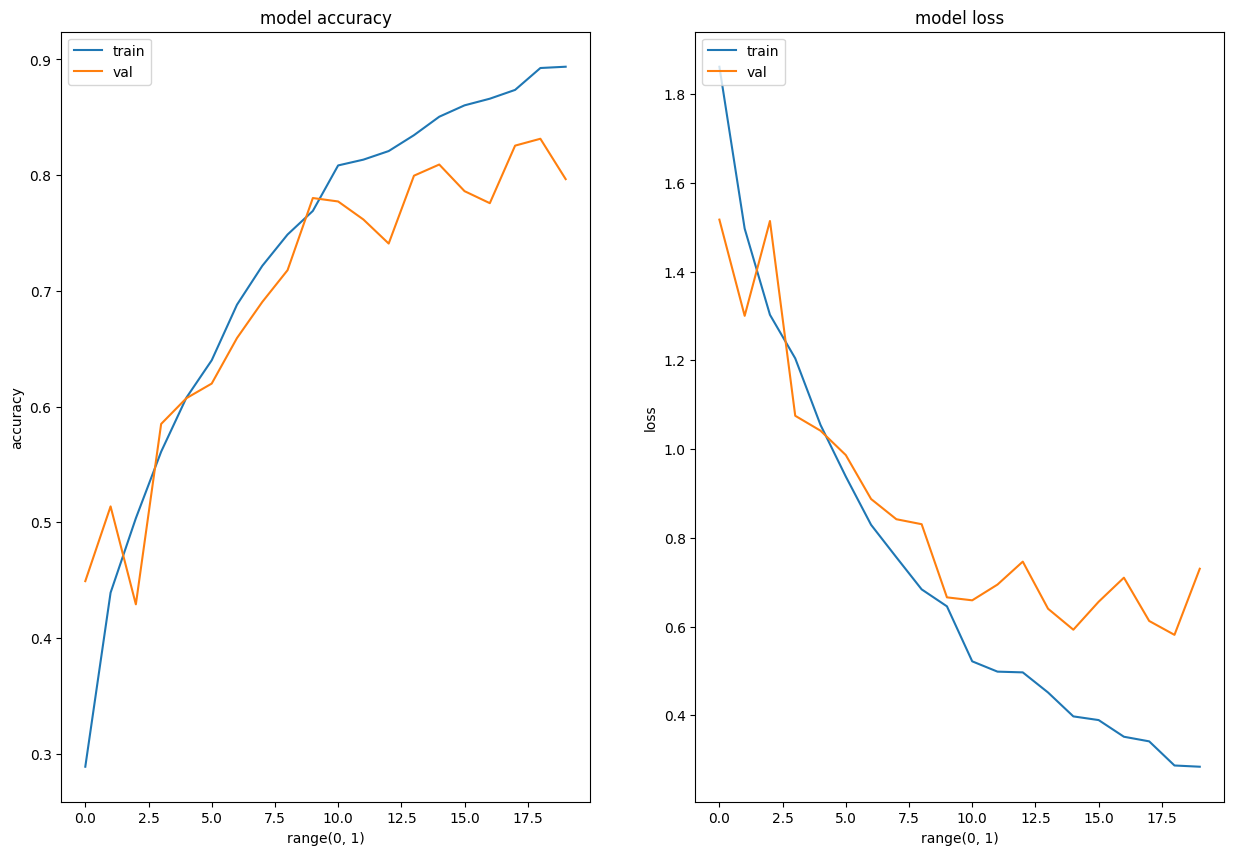

In [18]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

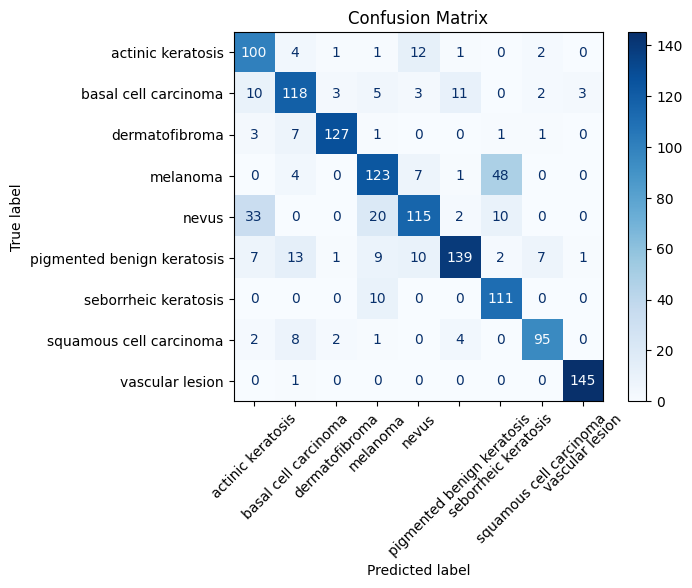

In [64]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Actual Class basal cell carcinoma
Predictive Class actinic keratosis


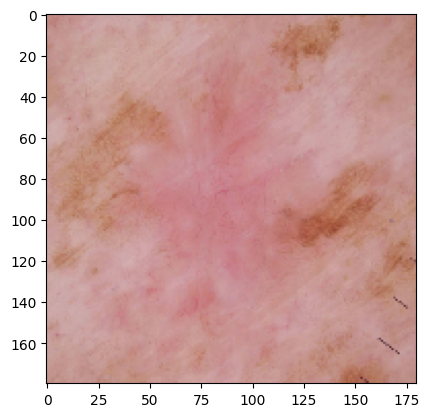

In [23]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

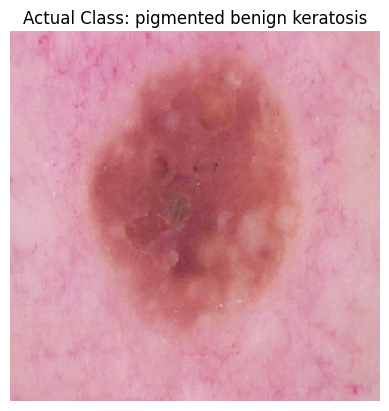

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: pigmented benign keratosis



In [40]:
from glob import glob

for i in range(1):  # test 1 random sample
    class_index = np.random.randint(len(class_names))
    image_paths = glob(os.path.join(data_dir_test, class_names[class_index], '*'))
    img_path = np.random.choice(image_paths)

    test_img = load_img(img_path, target_size=(180, 180))
    plt.imshow(test_img)
    plt.title(f"Actual Class: {class_names[class_index]}")
    plt.axis("off")
    plt.show()

    img_array = np.expand_dims(np.array(test_img)/255.0, axis=0)
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]

    print("Predicted Class:", pred_class)
    print()


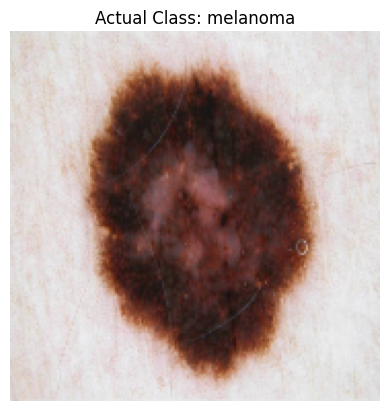

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: melanoma



In [61]:
from glob import glob

for i in range(1):  # test 1 random sample
    class_index = np.random.randint(len(class_names))
    image_paths = glob(os.path.join(data_dir_test, class_names[class_index], '*'))
    img_path = np.random.choice(image_paths)

    test_img = load_img(img_path, target_size=(180, 180))
    plt.imshow(test_img)
    plt.title(f"Actual Class: {class_names[class_index]}")
    plt.axis("off")
    plt.show()

    img_array = np.expand_dims(np.array(test_img)/255.0, axis=0)
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]

    print("Predicted Class:", pred_class)
    print()


In [66]:
# Save model in the new native format
model.save("skin_cancer_cnn_model.keras")
print("Model saved in Keras format successfully.")


Model saved in Keras format successfully.


In [67]:
from google.colab import files
files.download("skin_cancer_cnn_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>